# Strava EDA

## Data exploration : looking for a pattern in the user data



### Imports

In [1]:
# general
import subprocess
import calendar
from geopy.geocoders import Nominatim

# df and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# machine learning
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Getting data

We already fetched it in another notebook, I'll put the code later anyway

### Reading data

In [38]:
df = pd.read_csv('/content/drive/My Drive/Work/Strava project/data/my_activity_data=20240929010236.csv')
print('Dataframe Shape:', df.shape)
df.head()

Dataframe Shape: (302, 60)


,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,id,...,from_accepted_tag,pr_count,total_photo_count,has_kudoed,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state
0,2,Big Volume,15017.8,5788,5826,89.0,Run,Run,2.0,12525935628,...,False,1,3,False,225.0,64383208,1,a12525935628,maciH}beNfA|@VdAZr@j@x@Z|@`AnBHZ|@~@\tAp@dAVnA...,2
1,2,Football l'après-midi,1986.2,3113,3361,0.0,Soccer,Soccer,NaN,12516996825,...,False,0,0,False,138.0,64383208,1,a12516996825,NaN,2
2,2,VMA - 4*1000m allure 5k,7182.7,2653,2846,3.0,Run,Run,3.0,12495218617,...,False,0,1,False,106.0,64383208,1,a12495218617,agciHeedNZCr@QJKTc@BU?}@Ga@Oc@IIQIS?sBPa@@QHSP...,2
3,2,Séance de musculation en soirée,0.0,3711,3711,0.0,WeightTraining,WeightTraining,NaN,12494753465,...,False,0,0,False,8.0,64383208,1,a12494753465,NaN,2
4,2,Volume,8488.1,3443,3520,29.0,Run,Run,0.0,12473614224,...,False,0,0,False,129.0,64383208,1,a12473614224,}~biHcseNVC\MrAUd@Q`@GZ?v@HPAd@JpCT\H~@Ep@IX?f...,2


In [39]:
df.columns

Index(['resource_state', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'sport_type', 'workout_type', 'id',
       'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'trainer', 'commute', 'manual', 'private', 'visibility',
       'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'average_speed',
       'max_speed', 'average_cadence', 'average_temp', 'average_watts',
       'max_watts', 'weighted_average_watts', 'kilojoules', 'device_watts',
       'has_heartrate', 'average_heartrate', 'max_heartrate',
       'heartrate_opt_out', 'display_hide_heartrate_option', 'elev_high',
       'elev_low', 'upload_id', 'upload_id_str', 'external_id',
       'from_accepted_tag', 'pr_count', 'total_photo_count', 'has_kudoed',
       'suffer_score', 'athlete.id', 'athlete.resource_state', 'm

Creating dictionary to understand data

In [ ]:
data_dict = []

for col in df.columns:
    description = input(f"Enter description for {col}: ")
    possible_values = input(f"Enter possible values for {col} (if any, else leave blank): ")

    data_dict.append({"Feature": col, "Description": description, "Possible Values": possible_values})

dict_df = pd.DataFrame(data_dict)
dict_df.to_csv("data_dictionary.csv", index=False)

In [12]:
null_df = [[col, df[col].isnull().sum()] for col in df.columns]
print('Null Data:', df.isnull().sum().sum())
list(filter(lambda x: x[1]>0, null_df))

Null Data: 2753


[['workout_type', 171],
 ['location_city', 302],
 ['location_state', 302],
 ['gear_id', 152],
 ['average_cadence', 198],
 ['average_temp', 230],
 ['average_watts', 226],
 ['max_watts', 229],
 ['weighted_average_watts', 229],
 ['kilojoules', 226],
 ['device_watts', 226],
 ['average_heartrate', 17],
 ['max_heartrate', 17],
 ['elev_high', 36],
 ['elev_low', 36],
 ['upload_id', 2],
 ['upload_id_str', 2],
 ['external_id', 2],
 ['suffer_score', 12],
 ['map.summary_polyline', 138]]

We will only select the columns that are interesting for the research

### Data Cleaning

In [40]:
selected_columns = ['distance', 'moving_time', 'elapsed_time',
                    'total_elevation_gain', 'type','sport_type', 'id', 'start_date',
                    'start_date_local','location_country', 'achievement_count', 'kudos_count',
                    'comment_count','athlete_count', 'start_latlng',
                    'end_latlng', 'average_speed', 'max_speed', 'average_cadence',
                    'average_heartrate', 'max_heartrate', 'elev_high','elev_low',
                    'upload_id', 'external_id', 'pr_count', 'map.summary_polyline']
df = df[selected_columns]
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,start_date_local,location_country,...,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline
0,15017.8,5788,5826,89.0,Run,Run,12525935628,2024-09-28T15:58:58Z,2024-09-28T17:58:58Z,France,...,3.974,85.6,160.2,170.0,105.6,18.4,1.335498e+10,garmin_ping_373622138638,1,maciH}beNfA|@VdAZr@j@x@Z|@`AnBHZ|@~@\tAp@dAVnA...
1,1986.2,3113,3361,0.0,Soccer,Soccer,12516996825,2024-09-27T15:17:18Z,2024-09-27T17:17:18Z,France,...,2.734,65.2,162.1,186.0,72.4,71.9,1.334544e+10,garmin_ping_373357288224,0,NaN
2,7182.7,2653,2846,3.0,Run,Run,12495218617,2024-09-24T19:10:03Z,2024-09-24T21:10:03Z,France,...,4.156,85.8,159.2,179.0,103.4,95.6,1.332223e+10,garmin_ping_372645533630,0,agciHeedNZCr@QJKTc@BU?}@Ga@Oc@IIQIS?sBPa@@QHSP...
3,0.0,3711,3711,0.0,WeightTraining,WeightTraining,12494753465,2024-09-24T17:49:45Z,2024-09-24T19:49:45Z,France,...,0.000,NaN,90.0,132.0,0.0,0.0,1.332174e+10,garmin_ping_372633109243,0,NaN
4,8488.1,3443,3520,29.0,Run,Run,12473614224,2024-09-22T08:43:53Z,2024-09-22T10:43:53Z,France,...,4.156,84.6,159.4,172.0,85.4,24.4,1.329919e+10,garmin_ping_372009166308,0,}~biHcseNVC\MrAUd@Q`@GZ?v@HPAd@JpCT\H~@Ep@IX?f...


In [42]:
df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')
df = df.sort_values(by='start_date_local')

df['weekday'] = df['start_date_local'].dt.weekday
df['start_time'] = df['start_date_local'].dt.time
df['start_time'] = df['start_time'].astype(str)
df['start_date'] = df['start_date_local'].dt.date

df = df.drop('start_date_local', axis=1)
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time
301,3576.4,1091,1091,32.8,Run,Run,10290286182,2020-07-18,France,2,...,170.9,184.0,76.1,38.5,1.101782e+10,ZeppLife20200718202224.gpx,1,s_ciHa|eN|@W~A_@dA]jAMpAY`BWf@Gt@QlAKbCi@~@[|@...,5,20:22:25
300,2420.6,750,750,10.7,Run,Run,10290286166,2020-07-24,France,3,...,155.2,186.0,45.4,42.9,1.101782e+10,ZeppLife20200724120930.gpx,0,}p_iHiceN~@yANo@@[G_@Ua@]c@MEKA[H_@b@[r@a@p@Uf...,4,12:09:32
299,2463.9,723,723,0.0,Run,Run,10290286168,2020-08-27,France,1,...,179.8,188.0,99.0,98.8,1.101782e+10,ZeppLife20200827194233.gpx,0,NaN,3,19:42:35
298,2189.3,604,604,0.0,Run,Run,10290286167,2020-08-30,France,0,...,162.5,181.0,99.0,98.8,1.101782e+10,ZeppLife20200830161350.gpx,0,NaN,6,16:13:52
297,2123.6,599,599,0.0,Run,Run,10290286172,2020-09-03,France,1,...,168.0,185.0,99.0,98.8,1.101782e+10,ZeppLife20200903194236.gpx,0,NaN,3,19:42:38


In [43]:
df = df.drop(df[(df.distance < 1) & (df.type == 'Run')].index)
df = df.drop(df[(df.distance < 1) & (df.type == 'Ride')].index)
df = df.drop(df[df.average_speed > 30].index)
df = df.reset_index(drop=True)

In [44]:
def get_city_state_from_value(value):
    value = value.replace('[', '').replace(']', '').split(',')
    if value != ['']:
        try:  # Wrap the address parsing in try-except
            location = geolocator.reverse(', '.join(value))
            # Check if the split result has enough elements
            split_location = location[0].split(",")
            if len(split_location) >= 5:
                result = f'{split_location[1]}, {split_location[4]}'
            else:
                # Handle cases with fewer comma-separated values, e.g., return a default
                result = 'unknown'
        except (IndexError, AttributeError):
            # Handle errors if location or location[0] is invalid
            result = 'unknown'
    else:
        result = 'unknown'
    return result

In [45]:
geolocator = Nominatim(user_agent="strava_exploration_data")
df['location'] = df['start_latlng'].map(get_city_state_from_value)

In [46]:
df['elev_high'] = df['elev_high'].fillna(value=0)
df['elev_low'] = df['elev_low'].fillna(value=0)
df['upload_id'] = df['upload_id'].fillna(value='unknown')
df['external_id'] = df['external_id'].fillna(value='unknown')
df['map.summary_polyline'] = df['map.summary_polyline'].fillna(value='unknown')
df['average_cadence'] = df['average_cadence'].fillna(value=df['average_cadence'].mean())
df['average_heartrate'] = df['average_heartrate'].fillna(value=df['average_heartrate'].mean())
df['max_heartrate'] = df['max_heartrate'].fillna(value=df['max_heartrate'].mean())

In [47]:
df['moving_time_minutes'] = round(df['moving_time']/60, 2)
df['distance_km'] = round(df['distance'] / 1000, 2)
df['pace'] = df['moving_time_minutes'] / df['distance_km']
df['avg_speed_kmh'] = round(60/df['pace'], 2)
df['max_speed_kmh'] = round(df['max_speed']*3.6, 2)
df['elev'] = df['elev_high'] - df['elev_low']
df['year']= df['start_date'].map(lambda x: x.year)
df

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,weekday,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year
0,3576.4,1091,1091,32.8,Run,Run,10290286182,2020-07-18,France,2,...,5,20:22:25,"Boulevard de Strasbourg, Val-de-Marne",18.18,3.58,5.078212,11.82,17.93,37.6,2020
1,2420.6,750,750,10.7,Run,Run,10290286166,2020-07-24,France,3,...,4,12:09:32,"Le Tremblay, Val-de-Marne",12.50,2.42,5.165289,11.62,19.87,2.5,2020
2,2463.9,723,723,0.0,Run,Run,10290286168,2020-08-27,France,1,...,3,19:42:35,unknown,12.05,2.46,4.898374,12.25,15.05,0.2,2020
3,2189.3,604,604,0.0,Run,Run,10290286167,2020-08-30,France,0,...,6,16:13:52,unknown,10.07,2.19,4.598174,13.05,26.64,0.2,2020
4,2123.6,599,599,0.0,Run,Run,10290286172,2020-09-03,France,1,...,3,19:42:38,unknown,9.98,2.12,4.707547,12.75,15.41,0.2,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,8488.1,3443,3520,29.0,Run,Run,12473614224,2024-09-22,France,0,...,6,10:43:53,"Rue de Plaisance, Val-de-Marne",57.38,8.49,6.758539,8.88,14.96,61.0,2024
295,0.0,3711,3711,0.0,WeightTraining,WeightTraining,12494753465,2024-09-24,France,0,...,1,19:49:45,unknown,61.85,0.00,inf,0.00,0.00,0.0,2024
296,7182.7,2653,2846,3.0,Run,Run,12495218617,2024-09-24,France,0,...,1,21:10:03,"La Redoute, Val-de-Marne",44.22,7.18,6.158774,9.74,14.96,7.8,2024
297,1986.2,3113,3361,0.0,Soccer,Soccer,12516996825,2024-09-27,France,0,...,4,17:17:18,unknown,51.88,1.99,26.070352,2.30,9.84,0.5,2024


In [48]:
df['pace_sub_6'] = np.where(df['pace']<=6, True, False)
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,pace_sub_6
0,3576.4,1091,1091,32.8,Run,Run,10290286182,2020-07-18,France,2,...,20:22:25,"Boulevard de Strasbourg, Val-de-Marne",18.18,3.58,5.078212,11.82,17.93,37.6,2020,True
1,2420.6,750,750,10.7,Run,Run,10290286166,2020-07-24,France,3,...,12:09:32,"Le Tremblay, Val-de-Marne",12.50,2.42,5.165289,11.62,19.87,2.5,2020,True
2,2463.9,723,723,0.0,Run,Run,10290286168,2020-08-27,France,1,...,19:42:35,unknown,12.05,2.46,4.898374,12.25,15.05,0.2,2020,True
3,2189.3,604,604,0.0,Run,Run,10290286167,2020-08-30,France,0,...,16:13:52,unknown,10.07,2.19,4.598174,13.05,26.64,0.2,2020,True
4,2123.6,599,599,0.0,Run,Run,10290286172,2020-09-03,France,1,...,19:42:38,unknown,9.98,2.12,4.707547,12.75,15.41,0.2,2020,True


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              299 non-null    float64
 1   moving_time           299 non-null    int64  
 2   elapsed_time          299 non-null    int64  
 3   total_elevation_gain  299 non-null    float64
 4   type                  299 non-null    object 
 5   sport_type            299 non-null    object 
 6   id                    299 non-null    int64  
 7   start_date            299 non-null    object 
 8   location_country      299 non-null    object 
 9   achievement_count     299 non-null    int64  
 10  kudos_count           299 non-null    int64  
 11  comment_count         299 non-null    int64  
 12  athlete_count         299 non-null    int64  
 13  start_latlng          299 non-null    object 
 14  end_latlng            299 non-null    object 
 15  average_speed         2

In [65]:
df.describe().transpose()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,count,mean,std,min,25%,50%,75%,max
distance,299.0,3.648835e+03,4.070161e+03,0.000000e+00,0.000000e+00,2.023500e+03,6.409100e+03,2.130340e+04
moving_time,299.0,2.767572e+03,1.811400e+03,5.400000e+01,1.277500e+03,2.676000e+03,3.949500e+03,9.921000e+03
elapsed_time,299.0,2.828472e+03,1.840529e+03,5.700000e+01,1.334000e+03,2.826000e+03,3.971000e+03,1.106900e+04
total_elevation_gain,299.0,1.553411e+01,2.283818e+01,0.000000e+00,0.000000e+00,2.000000e+00,2.625000e+01,1.280000e+02
id,299.0,1.049498e+10,1.254340e+09,8.160896e+09,9.434253e+09,1.041500e+10,1.157304e+10,1.252594e+10
achievement_count,299.0,1.160535e+00,2.862799e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.400000e+01
kudos_count,299.0,1.270903e-01,3.978574e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
comment_count,299.0,1.337793e-02,1.412610e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
athlete_count,299.0,1.250836e+00,1.618048e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.800000e+01
average_speed,299.0,1.752405e+00,1.315964e+00,0.000000e+00,0.000000e+00,2.348000e+00,2.707500e+00,5.000000e+00


## Visualization

In [64]:
df.groupby('type')['distance'].nlargest(3)

type               
Ride            262    16772.9
                191    10302.0
                189     9000.0
Run             162    21303.4
                181    15025.2
                204    15017.9
Soccer          259     6546.1
                257     6322.3
                297     1986.2
Walk            23      1156.4
                159     1011.0
WeightTraining  40         0.0
                48         0.0
                57         0.0
Workout         26         0.0
                30         0.0
                50         0.0
Name: distance, dtype: float64

In [53]:
df.groupby('type')['moving_time_minutes'].nlargest(3)

type               
Ride            262     69.58
                191     35.97
                105     33.08
Run             162    165.35
                181    108.80
                261    108.22
Soccer          31     106.82
                44      98.05
                278     90.65
Walk            23      14.15
                159      6.18
WeightTraining  101    155.28
                128    127.22
                106    107.38
Workout         83     116.60
                133    108.97
                26     107.97
Name: moving_time_minutes, dtype: float64

In [56]:
# Select only numeric columns before grouping
numeric_cols = df.select_dtypes(include=['number']).columns
df.groupby('weekday')[numeric_cols].mean()

,distance,moving_time,elapsed_time,total_elevation_gain,id,achievement_count,kudos_count,comment_count,athlete_count,average_speed,...,elev_low,pr_count,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year
weekday,,,,,,,,,,,,,,,,,,,,,
0,4488.161111,2562.444444,2637.361111,20.269444,1.054262e+10,1.333333,0.111111,0.000000,1.111111,2.229917,...,21.169444,0.305556,0.0,42.707500,4.489167,inf,8.038611,13.259444,16.152778,2022.805556
1,3289.725000,2888.954545,2932.113636,13.629545,1.060522e+10,0.704545,0.113636,0.022727,1.000000,1.439182,...,15.868182,0.159091,1.0,48.150000,3.289545,inf,5.181364,8.905227,18.540909,2023.568182
2,3665.250000,2249.625000,2323.725000,15.370000,1.052713e+10,1.525000,0.100000,0.000000,1.100000,1.960625,...,41.835000,0.500000,2.0,37.494000,3.665500,inf,7.059000,12.395250,13.587500,2023.375000
3,3496.376316,2462.789474,2509.552632,14.586842,1.037775e+10,0.684211,0.026316,0.000000,1.000000,1.856158,...,32.326316,0.236842,3.0,41.046316,3.495526,inf,6.678947,9.976579,13.313158,2023.078947
4,2834.224390,2539.560976,2584.609756,11.668293,1.056518e+10,1.243902,0.121951,0.048780,1.024390,1.487829,...,30.360976,0.195122,4.0,42.325122,2.834390,inf,5.357317,9.979756,14.170732,2023.390244
5,2965.955263,3624.026316,3699.684211,16.015789,1.054926e+10,0.342105,0.184211,0.000000,1.000000,1.446105,...,23.742105,0.184211,5.0,60.399737,2.966316,inf,5.203684,8.676316,17.771053,2023.315789
6,4456.422581,2947.354839,3014.290323,17.083871,1.036051e+10,1.887097,0.193548,0.016129,2.064516,1.862194,...,34.787097,0.677419,6.0,49.123065,4.455968,inf,6.707903,12.116452,13.254839,2023.145161


<Axes: xlabel='weekday'>

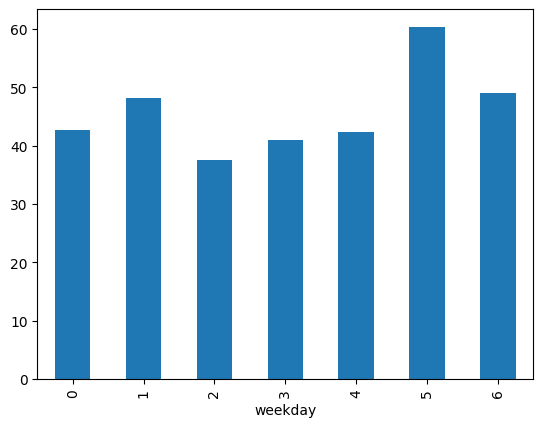

In [58]:
df.groupby('weekday')[numeric_cols].mean()['moving_time_minutes'].plot.bar()


Text(0.5, 1.0, 'Exercices')

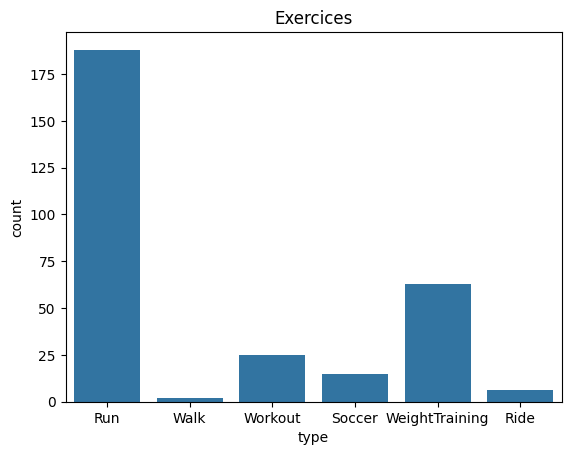

In [59]:
fig = sns.countplot(x='type', data=df).set_title('Exercices')
fig

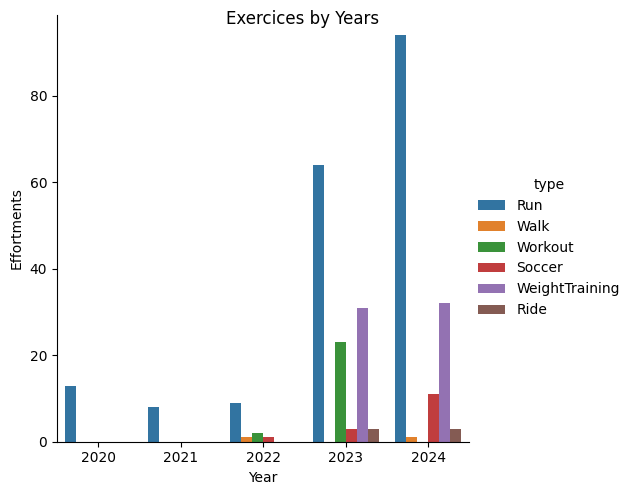

In [60]:
fig = sns.catplot(x='year', hue='type', data=df, kind='count')
fig.fig.suptitle('Exercices by Years')
fig.set_xlabels('Year')
fig.set_ylabels('Effortments')
fig

Text(0.5, 1.0, 'Average training time by day of the week')

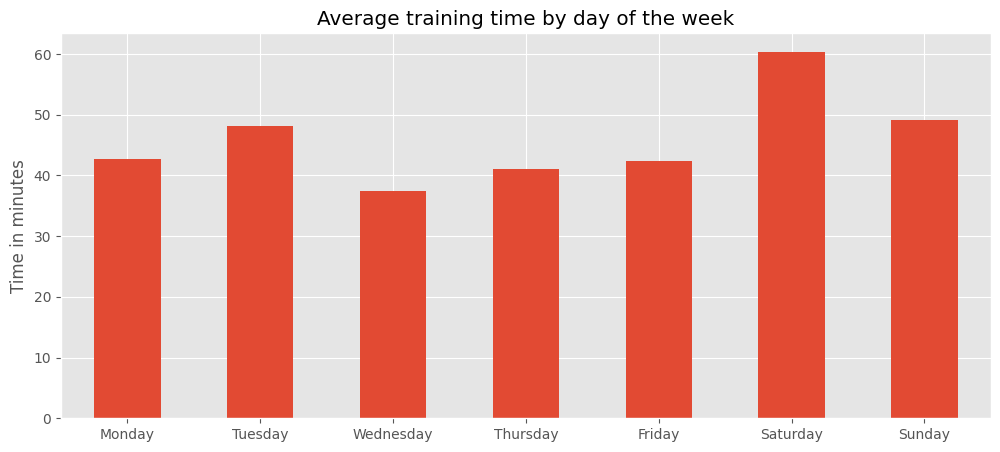

In [62]:
plt.style.use('ggplot')

df.groupby('weekday')[numeric_cols].mean()['moving_time_minutes'].plot(kind='bar', figsize=(12,5))
plt.xticks(list(range(7)), list(calendar.day_name), rotation='horizontal')
plt.xlabel('')
plt.ylabel('Time in minutes')
plt.title('Average training time by day of the week')

<Axes: xlabel='pace_sub_6'>

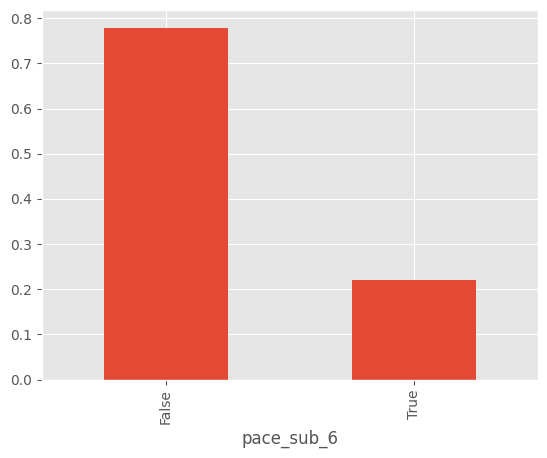

In [63]:
df['pace_sub_6'].value_counts(normalize = True).plot.bar()

## Focus on Running
Among the variables that influence running performance (intrinsically), I highlight elevation, heart rate and factors related to speed, so I wanted to relate it them to other fields.

### EDA

In [67]:
runs = df.loc[df['type'] == 'Run']
runs

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,pace_sub_6
0,3576.4,1091,1091,32.8,Run,Run,10290286182,2020-07-18,France,2,...,20:22:25,"Boulevard de Strasbourg, Val-de-Marne",18.18,3.58,5.078212,11.82,17.93,37.6,2020,True
1,2420.6,750,750,10.7,Run,Run,10290286166,2020-07-24,France,3,...,12:09:32,"Le Tremblay, Val-de-Marne",12.50,2.42,5.165289,11.62,19.87,2.5,2020,True
2,2463.9,723,723,0.0,Run,Run,10290286168,2020-08-27,France,1,...,19:42:35,unknown,12.05,2.46,4.898374,12.25,15.05,0.2,2020,True
3,2189.3,604,604,0.0,Run,Run,10290286167,2020-08-30,France,0,...,16:13:52,unknown,10.07,2.19,4.598174,13.05,26.64,0.2,2020,True
4,2123.6,599,599,0.0,Run,Run,10290286172,2020-09-03,France,1,...,19:42:38,unknown,9.98,2.12,4.707547,12.75,15.41,0.2,2020,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,4199.0,1697,1717,43.0,Run,Run,12426657162,2024-09-16,France,0,...,19:59:38,"Le Tremblay, Val-de-Marne",28.28,4.20,6.733333,8.91,19.53,40.0,2024,False
292,8743.5,3234,3267,105.0,Run,Run,12453430668,2024-09-19,France,2,...,19:39:28,"Rue de Plaisance, Val-de-Marne",53.90,8.74,6.167048,9.73,14.88,53.8,2024,False
294,8488.1,3443,3520,29.0,Run,Run,12473614224,2024-09-22,France,0,...,10:43:53,"Rue de Plaisance, Val-de-Marne",57.38,8.49,6.758539,8.88,14.96,61.0,2024,False
296,7182.7,2653,2846,3.0,Run,Run,12495218617,2024-09-24,France,0,...,21:10:03,"La Redoute, Val-de-Marne",44.22,7.18,6.158774,9.74,14.96,7.8,2024,False


In [68]:
runs.isnull().sum()


,0
distance,0
moving_time,0
elapsed_time,0
total_elevation_gain,0
type,0
sport_type,0
id,0
start_date,0
location_country,0
achievement_count,0


In [69]:
runs.max()


,0
distance,21303.4
moving_time,9921
elapsed_time,11069
total_elevation_gain,118.4
type,Run
sport_type,Run
id,12525935628
start_date,2024-09-28
location_country,France
achievement_count,24


In [70]:
runs.min()


,0
distance,124.7
moving_time,54
elapsed_time,57
total_elevation_gain,0.0
type,Run
sport_type,Run
id,8180479096
start_date,2020-07-18
location_country,France
achievement_count,0


In [71]:
runs.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
distance,188.0,5.474845e+03,3.807857e+03,1.247000e+02,2.033550e+03,5.028800e+03,8.062875e+03,2.130340e+04
moving_time,188.0,2.166202e+03,1.630631e+03,5.400000e+01,6.920000e+02,1.823500e+03,3.253000e+03,9.921000e+03
elapsed_time,188.0,2.251340e+03,1.701998e+03,5.700000e+01,7.080000e+02,1.930000e+03,3.358750e+03,1.106900e+04
total_elevation_gain,188.0,2.353351e+01,2.356167e+01,0.000000e+00,3.000000e+00,1.600000e+01,3.805000e+01,1.184000e+02
id,188.0,1.053861e+10,1.258129e+09,8.180479e+09,9.434253e+09,1.049793e+10,1.157299e+10,1.252594e+10
achievement_count,188.0,1.845745e+00,3.433499e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.400000e+01
kudos_count,188.0,1.808511e-01,4.616355e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
comment_count,188.0,5.319149e-03,7.293250e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
athlete_count,188.0,1.398936e+00,2.027986e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.800000e+01
average_speed,188.0,2.655319e+00,3.927120e-01,1.588000e+00,2.384500e+00,2.584500e+00,2.852500e+00,3.752000e+00


### Visualization

#### Comparing different statistics correlation

Does elevation tend to rise according to the activity time or according to the distance ?

Text(0.5, 1.0, 'Exercice Time vs Elevation')

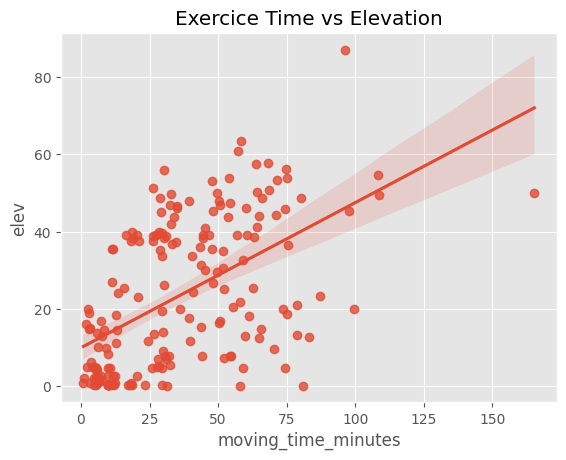

In [73]:
sns.regplot(x='moving_time_minutes', y = 'elev', data=runs).set_title("Exercice Time vs Elevation")

Text(0.5, 1.0, 'Distance vs Elevation')

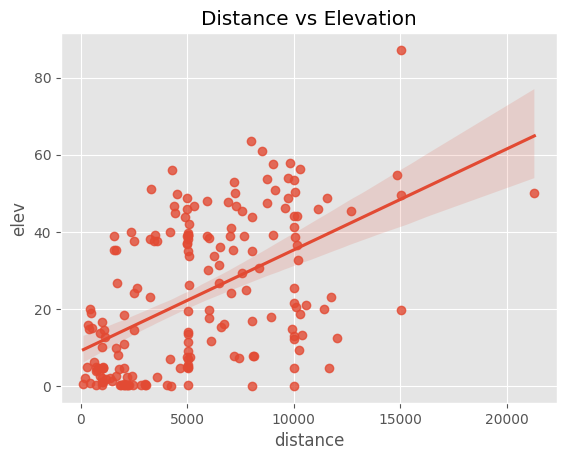

In [74]:
sns.regplot(x='distance', y = 'elev', data=runs).set_title("Distance vs Elevation")


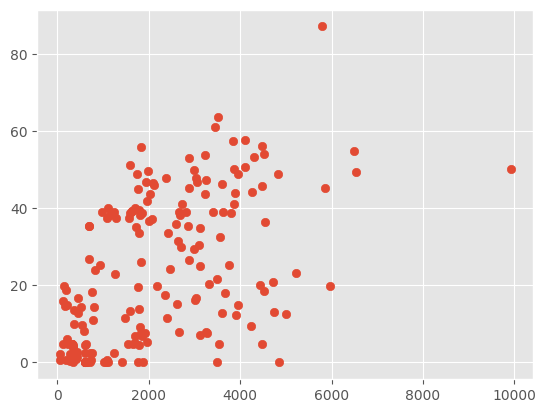

In [75]:
plt.scatter(runs['moving_time'],runs['elev'])
plt.show()

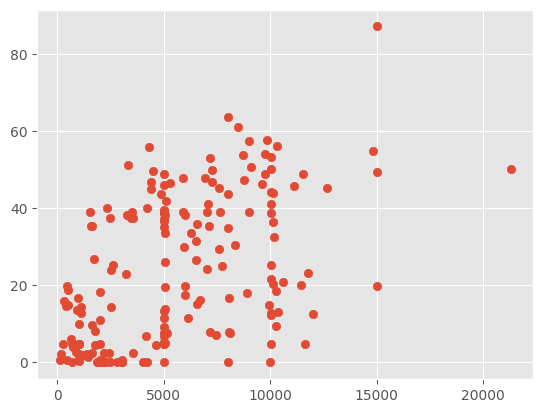

In [76]:
plt.scatter(runs['distance'],runs['elev'])
plt.show()

<Axes: xlabel='weekday'>

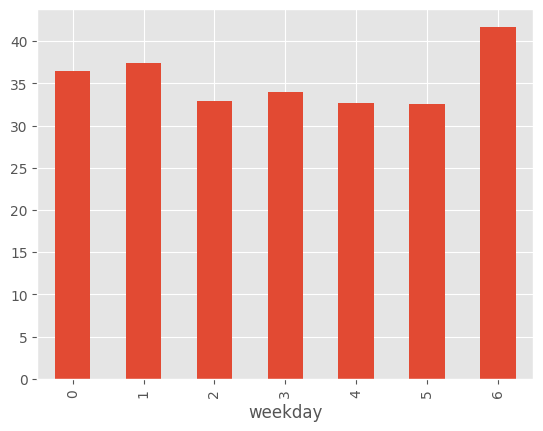

In [78]:
runs.groupby('weekday')[numeric_cols].mean()['moving_time_minutes'].plot.bar()

<Axes: xlabel='weekday'>

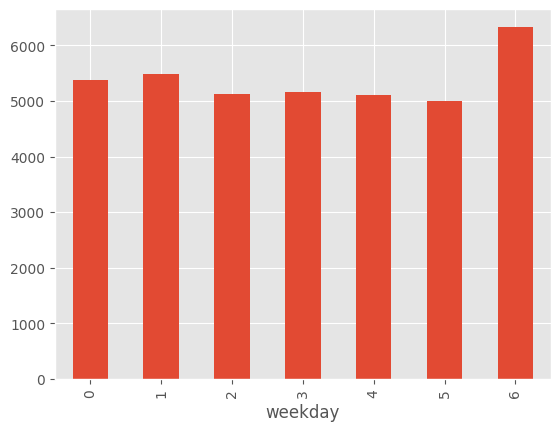

In [79]:
runs.groupby('weekday')[numeric_cols].mean()['distance'].plot.bar()

<Axes: xlabel='weekday'>

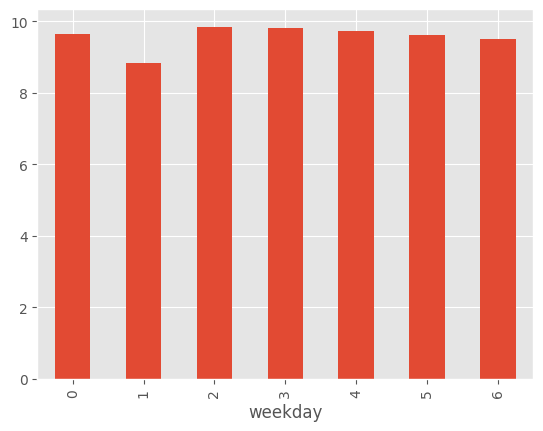

In [80]:
runs.groupby('weekday')[numeric_cols].mean()['avg_speed_kmh'].plot.bar()

<Axes: xlabel='weekday'>

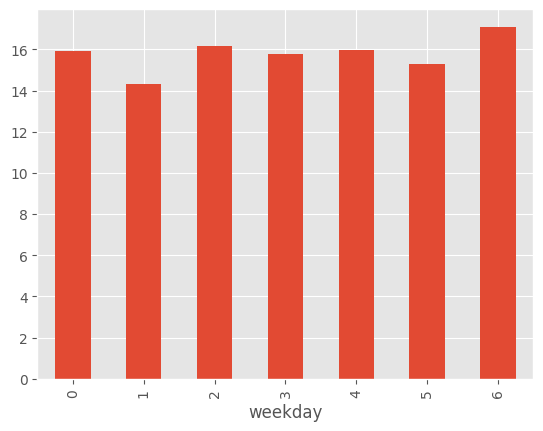

In [81]:
runs.groupby('weekday')[numeric_cols].mean()['max_speed_kmh'].plot.bar()

<Axes: xlabel='weekday'>

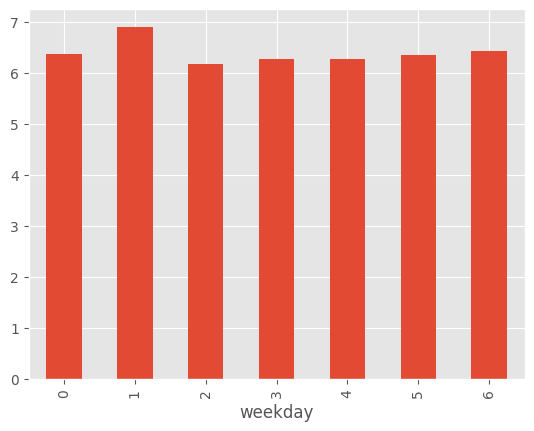

In [82]:
runs.groupby('weekday')[numeric_cols].mean()['pace'].plot.bar()

In [83]:
runs[runs['avg_speed_kmh'] == runs['avg_speed_kmh'].max()]

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,pace_sub_6
12,2247.2,599,599,0.0,Run,Run,10290286232,2020-12-04,France,6,...,16:53:35,unknown,9.98,2.25,4.435556,13.53,21.46,0.2,2020,True


Text(0.5, 1.0, 'Average Speed vs Distance')

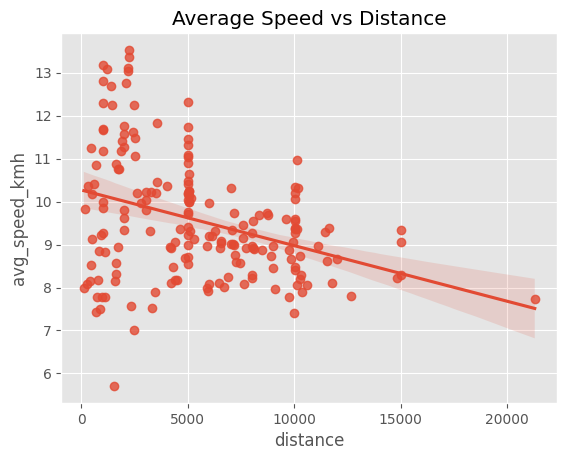

In [84]:
sns.regplot(x='distance', y = 'avg_speed_kmh', data=runs).set_title("Average Speed vs Distance")


Text(0.5, 1.0, 'Average Speed vs Moving Time')

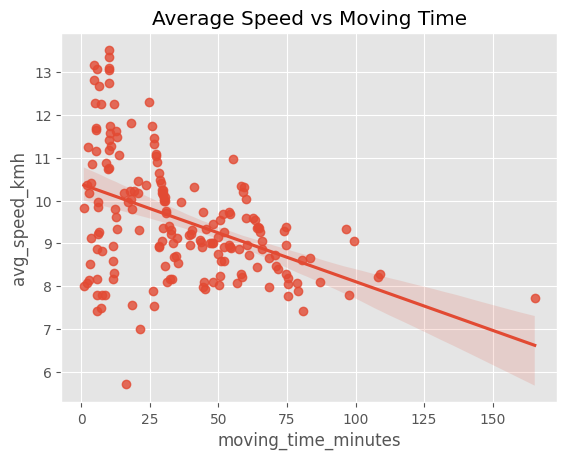

In [85]:
sns.regplot(x='moving_time_minutes', y = 'avg_speed_kmh', data=runs).set_title("Average Speed vs Moving Time")


Text(0.5, 1.0, 'Max Speed vs Distance')

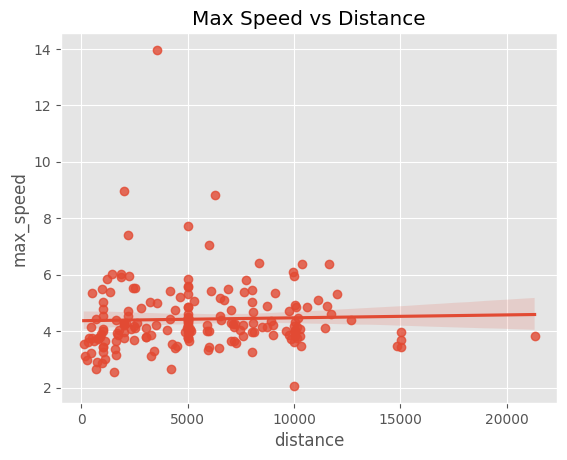

In [86]:
sns.regplot(x='distance', y = 'max_speed', data=runs).set_title("Max Speed vs Distance")


Text(0.5, 1.0, 'Moving Time vs Pace')

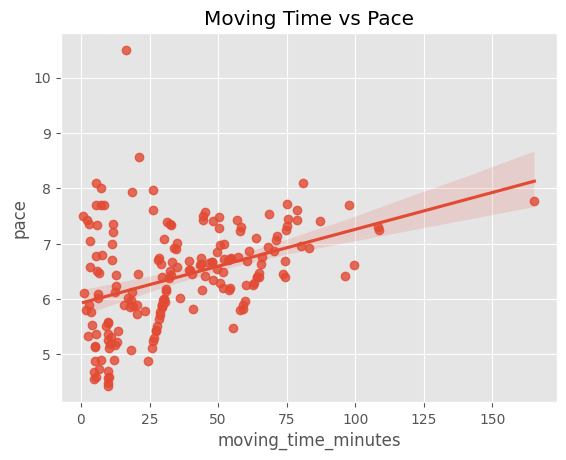

In [87]:
sns.regplot(x='moving_time_minutes', y = 'pace', data=runs).set_title("Moving Time vs Pace")


Text(0.5, 1.0, 'Distance vs Pace')

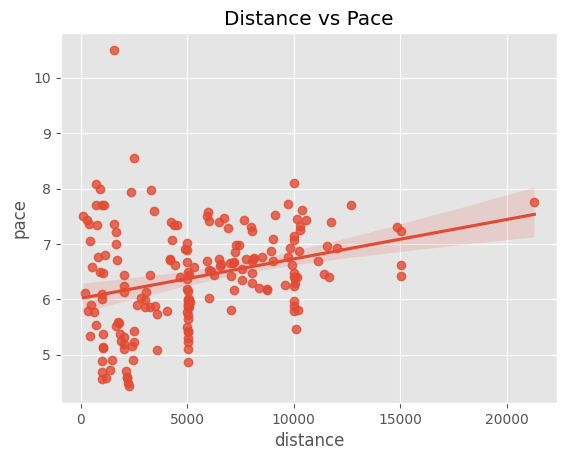

In [88]:
sns.regplot(x='distance', y = 'pace', data=runs).set_title("Distance vs Pace")


Text(0.5, 1.0, 'Pace vs Avg. Heart Rate')

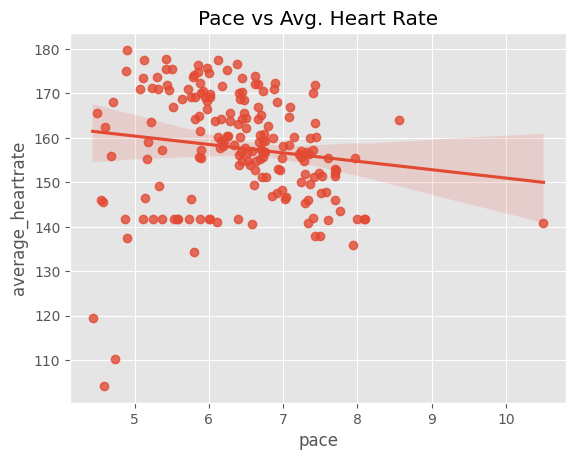

In [90]:
sns.regplot(x='pace', y='average_heartrate', data=runs).set_title("Pace vs Avg. Heart Rate")


Text(0.5, 1.0, 'Moving Time vs Avg. Heart Rate')

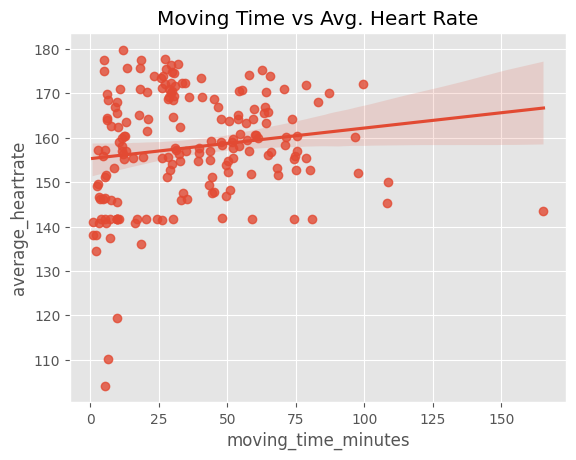

In [91]:
sns.regplot(x='moving_time_minutes', y='average_heartrate', data=runs).set_title("Moving Time vs Avg. Heart Rate")


Text(0.5, 1.0, 'Distance vs Avg. Heart Rate')

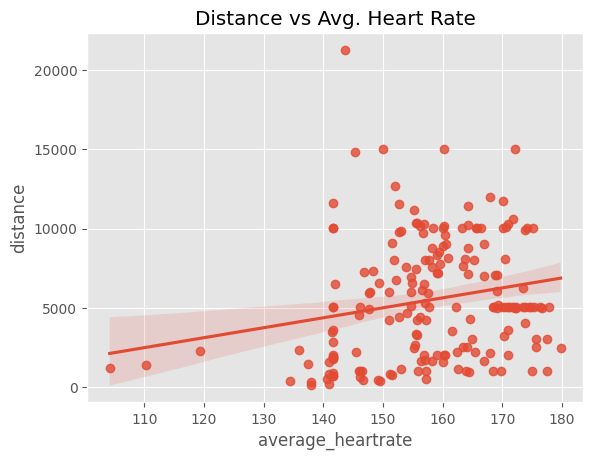

In [94]:
sns.regplot(x='average_heartrate', y='distance', data=runs).set_title("Distance vs Avg. Heart Rate")


#### Progression over time

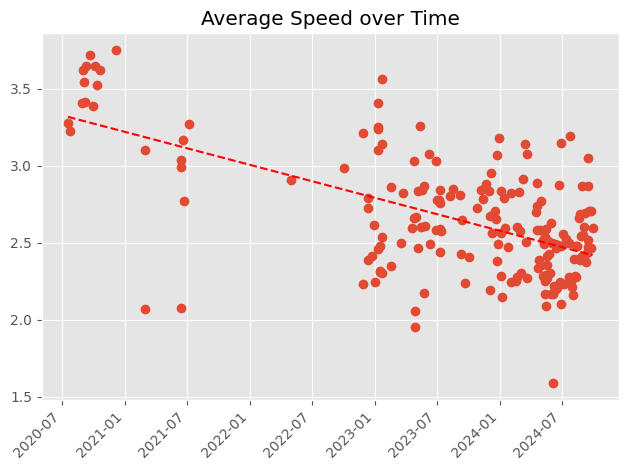

In [97]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(runs.start_date)
y = np.asarray(runs.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')

#add trend line
x2 = mdates.date2num(x)

z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

I've learned that running slower makes you become more fit, so this graph is an example of a misleading graph : I've been running more frequently but slower and longer

# Feature Selection

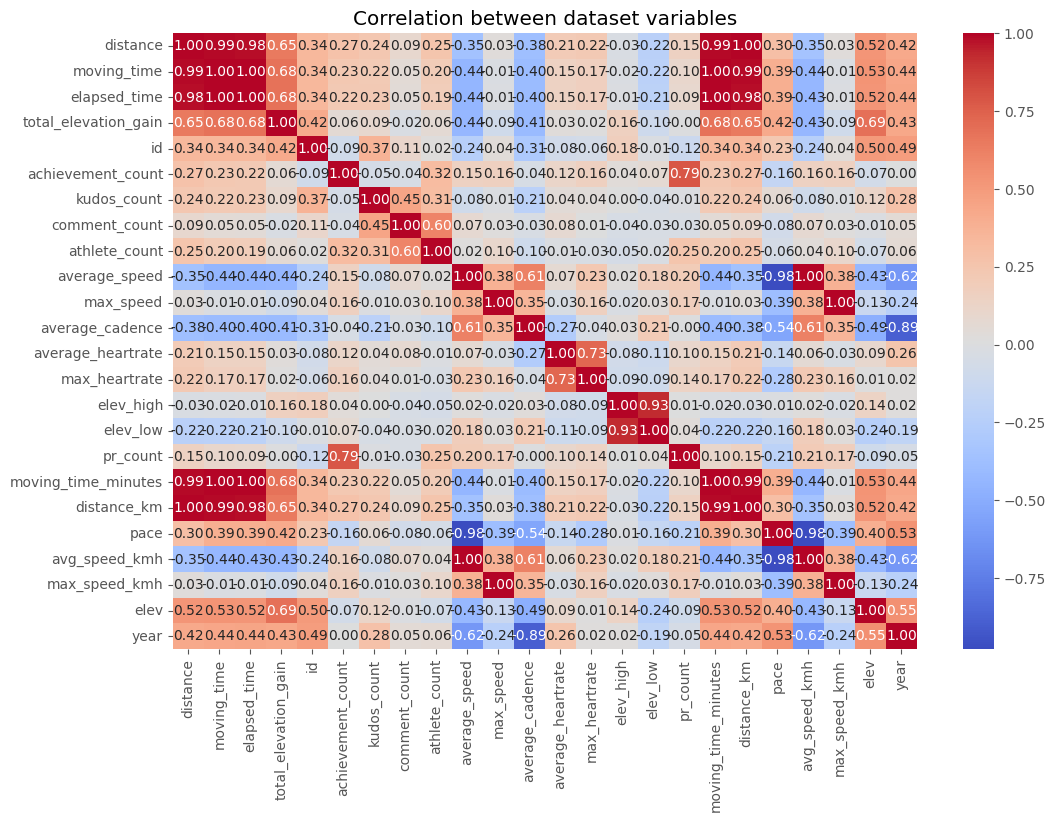

In [102]:
numeric_runs = runs.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr = numeric_runs.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation between dataset variables')
plt.show()

In [103]:
runs = runs.sample(frac=1).reset_index(drop=True)
categorical_cols = [col for col in runs.columns if runs[col].dtypes == 'O']
useless_vars = ['id', 'achievement_count', 'kudos_count', 'comment_count', 'pr_count']
tweak_runs = runs.drop(categorical_cols+useless_vars, axis=1)
tweak_runs

tweak_runs = tweak_runs[tweak_runs['elev_high'] >= 0]
tweak_runs = tweak_runs[tweak_runs['elev_low'] >= 0]


,distance,moving_time,elapsed_time,total_elevation_gain,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,...,elev_low,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,pace_sub_6
0,6566.3,2618,2621,24.0,2,2.508,4.394,83.300000,154.9,171.0,...,34.0,0,43.63,6.57,6.640791,9.04,15.82,15.2,2024,False
1,5148.0,1838,2956,12.1,1,2.801,4.020,98.421154,169.3,182.0,...,1.5,0,30.63,5.15,5.947573,10.09,14.47,7.6,2023,True
2,5035.2,1545,1548,9.3,1,3.259,7.722,98.421154,173.5,185.0,...,54.4,6,25.75,5.04,5.109127,11.74,27.80,4.7,2023,True
3,2420.6,750,750,10.7,1,3.227,5.520,161.300000,155.2,186.0,...,42.9,4,12.50,2.42,5.165289,11.62,19.87,2.5,2020,True
4,2636.0,933,936,35.1,1,2.825,4.300,98.421154,155.4,183.0,...,70.5,3,15.55,2.64,5.890152,10.19,15.48,25.4,2023,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,7176.1,2873,2966,42.0,1,2.498,3.634,81.500000,159.0,182.0,...,25.2,5,47.88,7.18,6.668524,9.00,13.08,53.0,2024,False
184,2031.4,632,635,26.4,1,3.214,3.960,98.421154,159.0,180.0,...,60.9,0,10.53,2.03,5.187192,11.57,14.26,4.7,2022,True
185,4199.0,1697,1717,43.0,1,2.474,5.424,82.700000,155.7,175.0,...,6.2,0,28.28,4.20,6.733333,8.91,19.53,40.0,2024,False
186,1125.1,461,486,12.4,1,2.441,3.640,98.421154,162.6,175.0,...,41.5,1,7.68,1.13,6.796460,8.83,13.10,12.8,2023,False


Selecting the 7 features that are most strongly correlated with pace using Chi-square test, which can help in reducing dimensionality and improving model performance

In [118]:
y = tweak_runs['pace']
X = tweak_runs.drop('pace', axis=1)
selector = SelectKBest(chi2, k=7)
best_features = selector.fit_transform(X, y.astype(int))
best_features


array([[6.56630000e+03, 2.61800000e+03, 2.62100000e+03, ...,
        8.33000000e+01, 4.36300000e+01, 1.52000000e+01],
       [5.14800000e+03, 1.83800000e+03, 2.95600000e+03, ...,
        9.84211538e+01, 3.06300000e+01, 7.60000000e+00],
       [5.03520000e+03, 1.54500000e+03, 1.54800000e+03, ...,
        9.84211538e+01, 2.57500000e+01, 4.70000000e+00],
       ...,
       [4.19900000e+03, 1.69700000e+03, 1.71700000e+03, ...,
        8.27000000e+01, 2.82800000e+01, 4.00000000e+01],
       [1.12510000e+03, 4.61000000e+02, 4.86000000e+02, ...,
        9.84211538e+01, 7.68000000e+00, 1.28000000e+01],
       [1.02030000e+03, 3.29000000e+02, 3.35000000e+02, ...,
        9.84211538e+01, 5.48000000e+00, 4.70000000e+00]])

In [119]:
selected_columns = X.columns[selector.get_support(indices=True)]
selected_columns

Index(['distance', 'moving_time', 'elapsed_time', 'total_elevation_gain',
       'average_cadence', 'moving_time_minutes', 'elev'],
      dtype='object')

Recursive Feature Elimination with Linear Regression as the estimator

In [121]:
def get_best_rfe_features(X,y, model):
    rfe = RFE(model, step=0.05).fit(X, y)
    selected_features = [i for i, j in zip(X.columns, rfe.support_) if j]
    return selected_features

In [123]:
y = tweak_runs['pace']
X = tweak_runs.drop('pace', axis=1)

lab_enc = preprocessing.LabelEncoder()
encoded_y = lab_enc.fit_transform(y)
model = LinearRegression()
best_reg = get_best_rfe_features(X, encoded_y, model)
best_reg

['moving_time',
 'athlete_count',
 'average_speed',
 'max_speed',
 'moving_time_minutes',
 'distance_km',
 'avg_speed_kmh',
 'max_speed_kmh',
 'year',
 'pace_sub_6']

In [125]:
y = tweak_runs['pace_sub_6']
X = tweak_runs.drop('pace_sub_6', axis=1)


model = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
best_class = get_best_rfe_features(X, y, model)
best_class

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic

['distance',
 'moving_time',
 'elapsed_time',
 'total_elevation_gain',
 'average_cadence',
 'average_heartrate',
 'max_heartrate',
 'elev_low',
 'moving_time_minutes',
 'max_speed_kmh']

# Machine Learning

## Clustering

In [131]:
X = tweak_runs.drop('pace', axis=1)
X = pd.get_dummies(X)

In [132]:
model = KMeans(n_clusters=4)
model.fit(X)

KMeans(n_clusters=4)

In [134]:
clustering_runs = tweak_runs.copy()
clustering_runs['Cluster'] = model.labels_

In [135]:
clustering_runs['Cluster'].value_counts()

,count
Cluster,
2,70
0,63
1,51
3,1


In [136]:
clustering_runs.groupby('Cluster').mean()

,distance,moving_time,elapsed_time,total_elevation_gain,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,...,elev_low,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,pace_sub_6
Cluster,,,,,,,,,,,,,,,,,,,,,
0,5642.944444,2182.825397,2301.365079,23.022222,1.142857,2.625159,4.507159,89.432540,161.044535,177.694923,...,43.200000,3.047619,36.380159,5.643492,6.415248,9.452063,16.225238,28.230159,2023.603175,0.301587
1,10160.284314,4141.176471,4249.117647,41.974510,2.294118,2.471431,4.389373,90.380543,160.163892,177.542553,...,35.384314,3.196078,69.020000,10.160196,6.782272,8.908431,15.801765,34.047059,2023.647059,0.098039
2,1673.990000,603.571429,622.800000,9.708571,1.000000,2.822629,4.377771,116.142912,152.771834,171.941439,...,63.667143,3.028571,10.059429,1.673714,6.114366,10.159571,15.760143,11.127143,2022.400000,0.542857
3,21303.400000,9921.000000,11069.000000,118.400000,1.000000,2.147000,3.840000,98.421154,143.600000,169.000000,...,46.000000,6.000000,165.350000,21.300000,7.762911,7.730000,13.820000,50.100000,2024.000000,0.000000


In [137]:
clustering_runs.groupby('Cluster').std()


,distance,moving_time,elapsed_time,total_elevation_gain,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,...,elev_low,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,pace_sub_6
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1038.830278,510.308526,563.125217,17.146489,0.503444,0.277985,1.022058,7.738274,10.367498,7.262850,...,24.508517,2.173362,8.505470,1.039265,0.650568,1.001597,3.679541,16.675805,0.708011,0.462633
1,1821.391595,863.523681,899.045886,25.684461,3.732528,0.210575,0.841490,7.924121,8.196762,5.993795,...,14.444312,2.236243,14.392674,1.821508,0.569521,0.760506,3.029237,19.963831,0.482640,0.300327
2,952.726267,365.366228,381.969860,12.976140,0.000000,0.508090,1.597543,32.732321,15.060028,12.500477,...,25.190732,2.070997,6.089461,0.952608,1.200799,1.837353,5.751086,13.561998,1.418307,0.501757
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
clustering_runs[clustering_runs['Cluster'] == 2]

,distance,moving_time,elapsed_time,total_elevation_gain,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,...,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,pace_sub_6,Cluster
3,2420.6,750,750,10.7,1,3.227,5.520,161.300000,155.2,186.0,...,4,12.50,2.42,5.165289,11.62,19.87,2.5,2020,True,2
4,2636.0,933,936,35.1,1,2.825,4.300,98.421154,155.4,183.0,...,3,15.55,2.64,5.890152,10.19,15.48,25.4,2023,True,2
5,1639.6,688,694,35.3,1,2.383,4.380,98.421154,158.2,171.0,...,6,11.47,1.64,6.993902,8.58,15.77,35.4,2023,False,2
11,2033.6,648,651,0.0,1,3.138,4.300,98.421154,171.0,178.0,...,3,10.80,2.03,5.320197,11.28,15.48,0.2,2024,True,2
15,730.6,337,337,3.0,1,2.168,2.916,82.100000,151.5,158.0,...,3,5.62,0.73,7.698630,7.79,10.50,4.0,2024,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2344.5,1115,1118,6.0,1,2.103,4.074,75.400000,136.0,165.0,...,4,18.58,2.34,7.940171,7.56,14.67,40.0,2024,False,2
182,519.9,205,208,14.1,1,2.536,3.760,98.421154,140.7,168.0,...,5,3.42,0.52,6.576923,9.12,13.54,15.0,2023,False,2
184,2031.4,632,635,26.4,1,3.214,3.960,98.421154,159.0,180.0,...,0,10.53,2.03,5.187192,11.57,14.26,4.7,2022,True,2
186,1125.1,461,486,12.4,1,2.441,3.640,98.421154,162.6,175.0,...,1,7.68,1.13,6.796460,8.83,13.10,12.8,2023,False,2


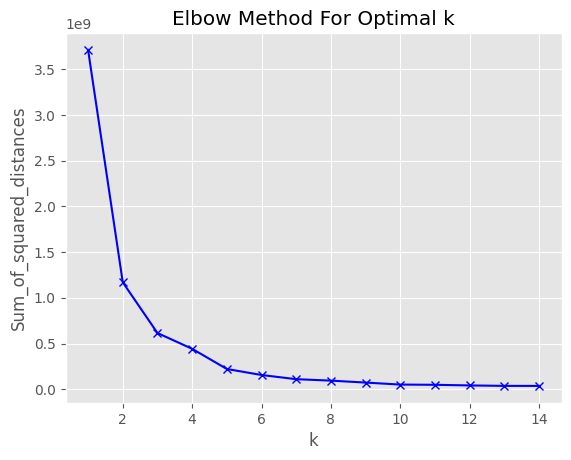

In [139]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Regression

In [141]:
y = tweak_runs['pace']
X = tweak_runs[best_reg]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [142]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [143]:
r_sq = model.score(X, y)
print('R²:', r_sq)

R²: 0.971255192620149


In [144]:
print('Intercept:', model.intercept_)

Intercept: 151.53059857261425


In [145]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
moving_time,0.077338
athlete_count,0.003511
average_speed,0.252404
max_speed,-43.093134
moving_time_minutes,-4.619253
distance_km,-0.148758
avg_speed_kmh,-0.747938
max_speed_kmh,11.968340
year,-0.068514
pace_sub_6,0.163500


In [146]:
y_pred = model.predict(X_test)

In [147]:
against_df = pd.DataFrame({'predicted': y_pred, 'true_value': y_test.to_list()})
against_df.head()

,predicted,true_value
0,6.019886,5.857988
1,7.307478,7.207317
2,6.348086,6.446571
3,5.378935,5.333333
4,7.709822,7.715897


MSE: 0.018419881651066526


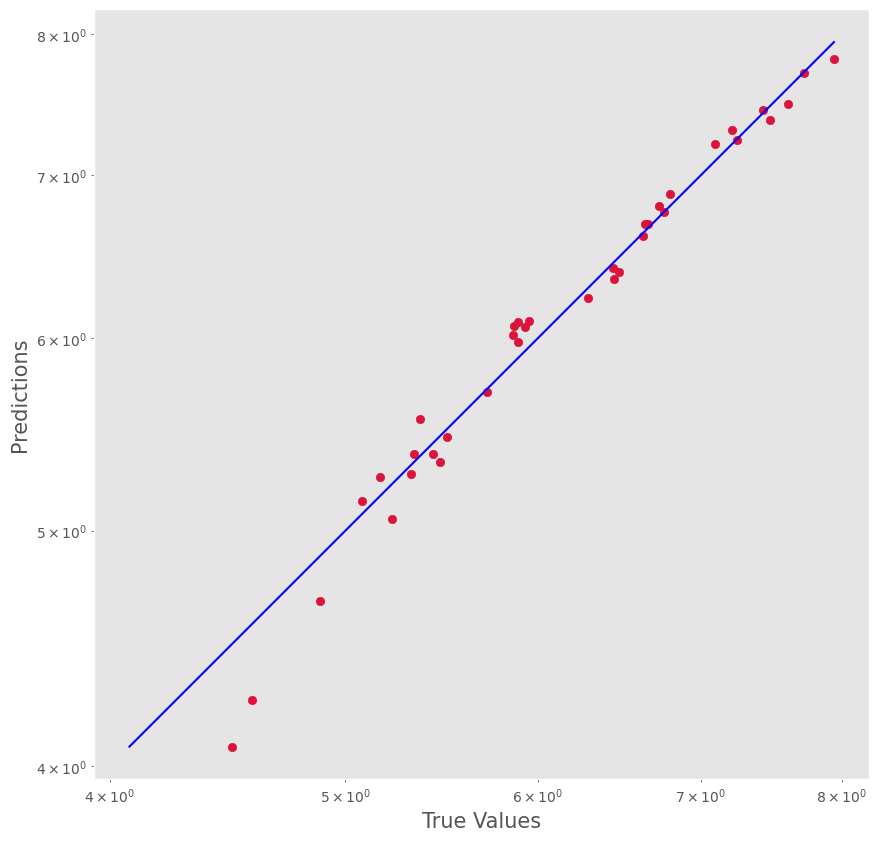

In [148]:
print('MSE:', metrics.mean_squared_error(y_test, y_pred))

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Classification

In [152]:
y = tweak_runs['pace_sub_6']
X = tweak_runs[best_class]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [153]:
model = make_pipeline(StandardScaler(), SGDClassifier())
model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [154]:
r_sq = model.score(X, y)
print('Determination Coefficient (R²):', r_sq)

Determination Coefficient (R²): 0.8864864864864865


In [155]:
y_pred = model.predict(X_test)


In [156]:
against_df = pd.DataFrame({'predicted': y_pred, 'true_value': y_test.to_list()})
against_df.head()

,predicted,true_value
0,False,False
1,False,False
2,False,False
3,False,True
4,False,False


In [157]:
accuracy_score(y_test, y_pred)

0.8918918918918919

In [158]:
accuracy_score(y_test, y_pred, normalize=False)

33.0

In [159]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm

array([[26,  2],
       [ 2,  7]])

Accuracy: 0.8918918918918919


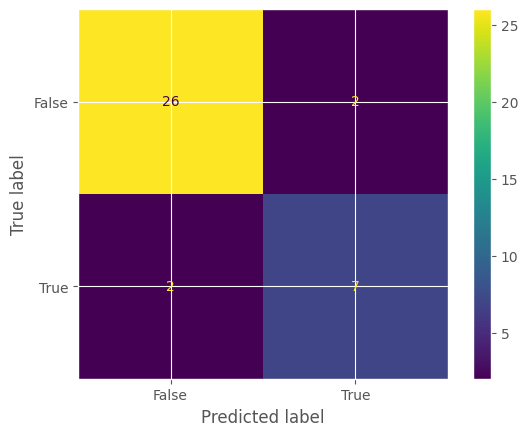

In [160]:
print('Accuracy:', accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

disp.plot()
plt.show()